In [1]:
import numpy as np 
import pandas as pd 
import os


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.12.0


In [3]:
train_dir = Path('../dataset/')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir = Path('../dataset/test/')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('../dataset/validation/')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
def image_processing(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3165

Number of different labels: 30

Labels: ['kentang_goreng' 'bakso_kuah' 'kacang_rebus' 'sayur_asam' 'semangka'
 'ayam_pop' 'cumi_tepung' 'tahu_goreng' 'nanas' 'sayur_bayam'
 'ikan_goreng' 'opor_ayam' 'gado_gado' 'pisang' 'telur_balado'
 'sate_bakar' 'pear' 'mangga' 'apel' 'nasi_goreng' 'lemon' 'mie_kuah'
 'somay' 'tempe_goreng' 'pempek' 'daging_rendang' 'ayam_goreng'
 'gulai_ikan' 'telur_dadar' 'mie_goreng']


In [9]:
train_df.head(5)

,Filepath,Label
0,../dataset/train/kentang_goreng/woman-eating-f...,kentang_goreng
1,../dataset/train/bakso_kuah/d778725b2347d6b702...,bakso_kuah
2,../dataset/train/kentang_goreng/Seasoned-Fries...,kentang_goreng
3,../dataset/train/kacang_rebus/kacang-rebus-530...,kacang_rebus
4,../dataset/test/sayur_asam/640px-Sayur_asem_ve...,sayur_asam


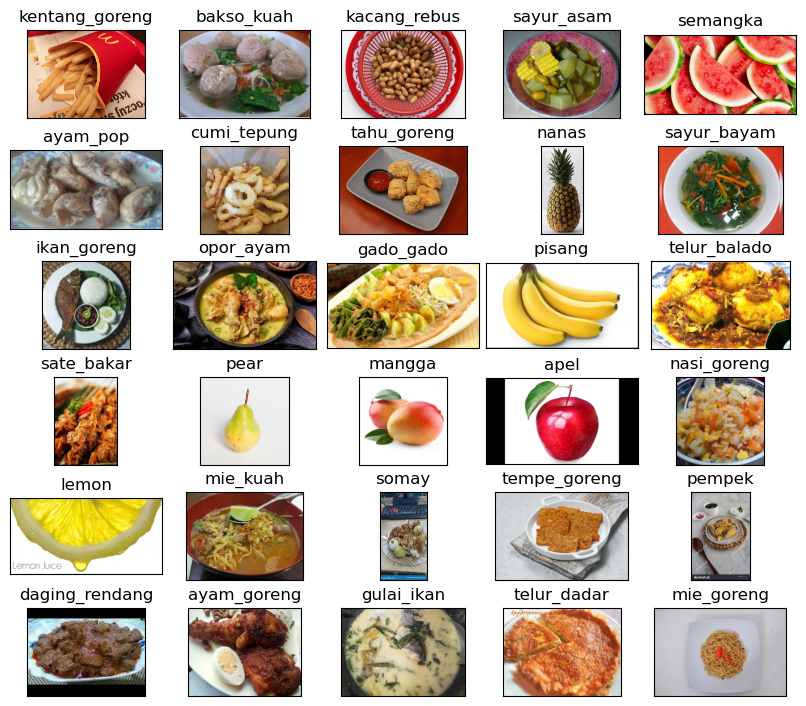

In [10]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3165 validated image filenames belonging to 30 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 498 validated image filenames belonging to 30 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 498 validated image filenames belonging to 30 classes.


In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [16]:
# Setting Callbacks
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% accuracy in training and 95% in validation, so cancelling training!")
            self.model.stop_training = True

callbackTraining = myCallback()

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224), 
    tf.keras.layers.Normalization(axis=-1),
    pretrained_model,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(30, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model (initial training)
history = model.fit(
    train_images, 
    validation_data=val_images, 
    batch_size=32, 
    callbacks=[callbackTraining],
    epochs=50)

Epoch 1/50


2023-12-04 09:22:28.992848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-04 09:22:29.024388: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


99/99 [==============================] - ETA: 0s - loss: 3.0942 - accuracy: 0.1735

2023-12-04 09:23:38.091871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 81s 798ms/step - loss: 3.0942 - accuracy: 0.1735 - val_loss: 2.5688 - val_accuracy: 0.4076
Epoch 2/50
99/99 [==============================] - 78s 787ms/step - loss: 2.1096 - accuracy: 0.5476 - val_loss: 1.5071 - val_accuracy: 0.7289
Epoch 3/50
99/99 [==============================] - 74s 746ms/step - loss: 1.2843 - accuracy: 0.7368 - val_loss: 0.9112 - val_accuracy: 0.8213
Epoch 4/50
99/99 [==============================] - 74s 752ms/step - loss: 0.8820 - accuracy: 0.8161 - val_loss: 0.6193 - val_accuracy: 0.8815
Epoch 5/50
99/99 [==============================] - 75s 762ms/step - loss: 0.6699 - accuracy: 0.8512 - val_loss: 0.4668 - val_accuracy: 0.9157
Epoch 6/50
99/99 [==============================] - 74s 750ms/step - loss: 0.5456 - accuracy: 0.8736 - val_loss: 0.3699 - val_accuracy: 0.9357
Epoch 7/50
99/99 [==============================] - 74s 746ms/step - loss: 0.4542 - accuracy: 0.8986 - val_loss: 0.3052 - val_accuracy: 0.9458
Epoch 8/50

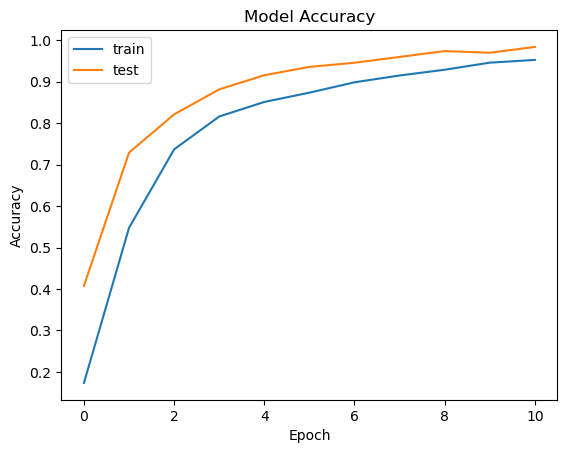

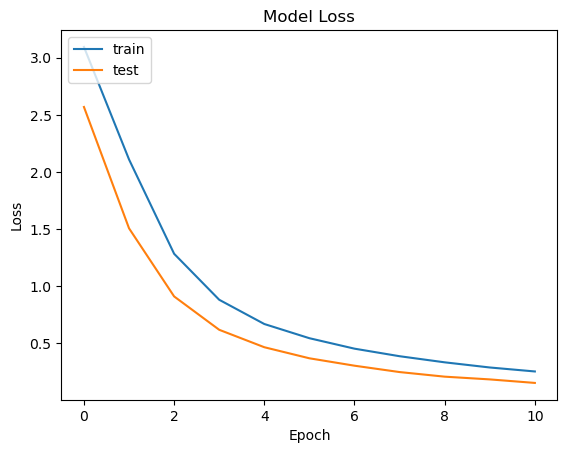

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# Save the best model during initial training
checkpoint_path = "initial_training_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)


In [20]:
# Setting Callbacks
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% accuracy in training and 95% in validation, so cancelling training!")
            self.model.stop_training = True

callbackFineTuning = myCallback()

In [23]:
# Unfreeze some layers for fine-tuning
for layer in model.layers[:100]:  # Menggunakan layers langsung dari model yang telah Anda definisikan sebelumnya
    layer.trainable = True

# Recompile the model with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Continue training with fine-tuning
history_fine_tuning = model.fit(
    train_images, 
    validation_data=val_images, 
    callbacks=[callbackFineTuning],
    batch_size=32, 
    epochs=50)


Epoch 1/50


2023-12-04 10:01:38.563149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - ETA: 0s - loss: 1.1378 - accuracy: 0.6891

2023-12-04 10:03:52.040383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 144s 1s/step - loss: 1.1378 - accuracy: 0.6891 - val_loss: 0.1728 - val_accuracy: 0.9618
Epoch 2/50
99/99 [==============================] - 152s 2s/step - loss: 0.6240 - accuracy: 0.8474 - val_loss: 0.1873 - val_accuracy: 0.9558
Epoch 3/50
99/99 [==============================] - 141s 1s/step - loss: 0.4675 - accuracy: 0.8904 - val_loss: 0.1834 - val_accuracy: 0.9518
Epoch 4/50
99/99 [==============================] - 155s 2s/step - loss: 0.3643 - accuracy: 0.9201 - val_loss: 0.1703 - val_accuracy: 0.9518
Epoch 5/50
99/99 [==============================] - 144s 1s/step - loss: 0.2965 - accuracy: 0.9378 - val_loss: 0.1415 - val_accuracy: 0.9618
Epoch 6/50
99/99 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9564
Reached 95% accuracy in training and 95% in validation, so cancelling training!
99/99 [==============================] - 140s 1s/step - loss: 0.2437 - accuracy: 0.9564 - val_loss: 0.1186 - val_accuracy: 0.9719


In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

2023-12-04 10:17:02.431141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 13s 788ms/step


['ikan_goreng',
 'nasi_goreng',
 'cumi_tepung',
 'ayam_goreng',
 'telur_balado',
 'ikan_goreng',
 'telur_balado',
 'daging_rendang',
 'cumi_tepung',
 'pear',
 'nasi_goreng',
 'sayur_asam',
 'cumi_tepung',
 'pisang',
 'gado_gado',
 'pisang',
 'semangka',
 'sayur_asam',
 'bakso_kuah',
 'sayur_asam',
 'cumi_tepung',
 'cumi_tepung',
 'kacang_rebus',
 'mie_goreng',
 'mie_kuah',
 'mie_kuah',
 'ikan_goreng',
 'kentang_goreng',
 'pempek',
 'ikan_goreng',
 'kentang_goreng',
 'sate_bakar',
 'nasi_goreng',
 'pempek',
 'opor_ayam',
 'telur_dadar',
 'apel',
 'daging_rendang',
 'tempe_goreng',
 'mangga',
 'mie_kuah',
 'kacang_rebus',
 'sayur_asam',
 'tempe_goreng',
 'tempe_goreng',
 'bakso_kuah',
 'lemon',
 'telur_balado',
 'bakso_kuah',
 'ikan_goreng',
 'pisang',
 'ayam_pop',
 'tempe_goreng',
 'tahu_goreng',
 'apel',
 'daging_rendang',
 'mie_kuah',
 'telur_balado',
 'mie_goreng',
 'gado_gado',
 'mie_goreng',
 'tempe_goreng',
 'tempe_goreng',
 'telur_dadar',
 'cumi_tepung',
 'gulai_ikan',
 'pear',
 

In [25]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [26]:
# Convert the model to .h5 format
model.save('save_model.h5')

In [27]:
# Convert the model to tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('save_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmp5joe7_rf/assets


INFO:tensorflow:Assets written to: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmp5joe7_rf/assets
2023-12-04 10:18:09.143223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-04 10:18:09.143242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-04 10:18:09.144023: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmp5joe7_rf
2023-12-04 10:18:09.166488: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-12-04 10:18:09.166505: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmp5joe7_rf
2023-12-04 10:18:09.239069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-12-04 10:18:09.262515: I tensorflow/cc/saved_model/load